In [1]:
import os
import sqlite3
from sqlalchemy import create_engine,  MetaData
import pandas as pd

from cities.utils.data_grabber import find_repo_root
from cities.utils.sql_data_grabber import list_csvs, DataGrabberDB 
from cities.utils.data_grabber import (DataGrabberCSV,
                                       list_available_features)
import time 
import logging


import matplotlib.pyplot as plt

logging.disable(logging.WARNING)

root = find_repo_root()

level = 'counties'

features = list_available_features()
features_msa = list_available_features("msa")

#level = 'msa' #'counties'

In [18]:

db_grabbers = {'counties': DataGrabberDB, 'msa': DataGrabberDB}

data_grabber_db = DataGrabberDB()
data_grabber_csv = DataGrabberCSV()

feature = features[0]

data_grabber_db.get_features_wide(features)
data_grabber_csv.get_features_wide(features)

data_grabber_db.get_features_std_wide(features)
data_grabber_csv.get_features_std_wide(features)

data_grabber_db.get_features_long(features)
data_grabber_csv.get_features_long(features)

data_grabber_db.get_features_std_long(features)
data_grabber_csv.get_features_std_long(features)

for feature in features:
    assert data_grabber_db.wide[feature].equals(data_grabber_csv.wide[feature])
    assert data_grabber_db.std_wide[feature].equals(data_grabber_csv.std_wide[feature])
    assert data_grabber_db.long[feature].equals(data_grabber_csv.long[feature])
    assert data_grabber_db.std_long[feature].equals(data_grabber_csv.std_long[feature])



In [ ]:

data_grabber_db.get_features_wide(features)
data_grabber_db.get_features_std_wide(features)
data_grabber_db.get_features_long(features)
data_grabber_db.get_features_std_long(features)


data_grabber_csv.get_features_std_wide(features)
data_grabber_csv.get_features_long(features)
data_grabber_csv.get_features_std_long(features)

for feature in features:
    assert data_grabber_db.wide[feature].equals(data_grabber_csv.wide[feature])
    assert data_grabber_db.wide_std[feature].equals(data_grabber_csv.wide_std[feature])
    assert data_grabber_db.long[feature].equals(data_grabber_csv.long[feature])
    assert data_grabber_db.long_std[feature].equals(data_grabber_csv.long_std[feature])



In [2]:
database_paths = {
    'counties': os.path.join(root, "data/sql/counties_database.db"),
    'msa': os.path.join(root, "data/sql/msa_database.db"),
}

database_path = database_paths[level]


if not os.path.exists(database_path):
    print("Database not found at", database_path)

engine = create_engine(f'sqlite:///{database_path}', echo=True)

metadata = MetaData()
metadata.reflect(bind=engine)
table_names = metadata.tables.keys()
print(len(table_names))





200


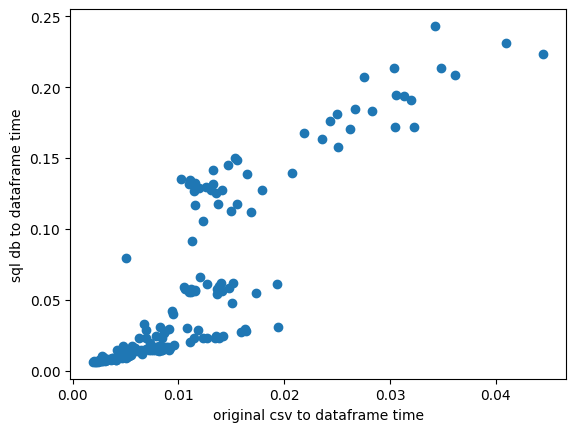

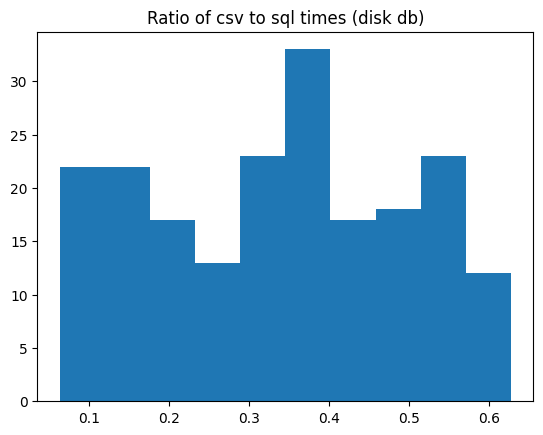

In [5]:
# test speed

engine.dispose()
engine = create_engine(f'sqlite:///{database_path}', echo=True)
metadata = MetaData()
metadata.reflect(bind=engine)
table_names = metadata.tables.keys()

sql_times = []
df_times = []
for csv in csv_list:
    assert csv[:-4] in table_names
    sql_start = time.time()
    df_from_sql = pd.read_sql_table(csv[:-4], con=engine)
    sql_end = time.time()
    sql_times.append(sql_end - sql_start)
    df_start = time.time()
    df_from_csv = pd.read_csv(os.path.join(data_dir, csv))
    df_end = time.time()
    df_times.append(df_end - df_start)
    assert df_from_sql.equals(df_from_csv)

plt.scatter(x = df_times, y = sql_times)
plt.xlabel("original csv to dataframe time")
plt.ylabel("sql db to dataframe time")
plt.show()

proportions =  [df / sql for df, sql in zip(df_times, sql_times)]
plt.hist(proportions)
plt.title("Ratio of csv to sql times (disk db)")

plt.show()
